# Machine Learning Engineer Nanodegree
## Capstone Project
Michel Moreau  
August 5th, 2019

## I. Definition

### Project Overview
[**CellSignal** - _Disentangling biological signal from experimental noise in cellular images_](https://www.rxrx.ai/)

#### Introduction
My final project is to participale in the NeurIPS competition on Kaggle called **CellSignal** - _Disentangling biological signal from experimental noise in cellular images_. More information about this competition is available here:  
- Competition's website https://www.rxrx.ai  
- Kaggle competition's link: https://www.kaggle.com/c/recursion-cellular-image-classification/overview


#### Domain Background  
Recursion Pharmaceuticals, creators of the industry’s largest dataset of biological images, generated entirely in-house, believes AI has the potential to dramatically improve and expedite the drug discovery process. More specifically, machine learning could help understand how drugs interact with human cells.

This competition is designed to disentangle experimental noise from real biological signals. The goal is to classify images of cells under one of 1,108 different genetic perturbations (siRNA), and thus eliminate the noise introduced by technical execution and environmental variation between \[drug\] experiments.

If successful, it could dramatically improve the industry’s ability to model cellular images according to their relevant biology. In turn, applying AI could greatly decrease the cost of treatments, and ensure these treatments get to patients faster.

### Problem Statement
This is a multiclass classification problem based on 6-channel fluorescent microscopy labeled images having a size 512x512 pixels.

In plain english, based on 6-grayscale 512x512 images representing a single site of same-type cells, we must be able to detect the right genetic perturbation (siRNA) this site was altered with.

Thus, the inputs will be 6x512x512 tensors and the output is a genetic perturbation (siRNA) represented by an integer ranging from 1 to 1,108.

Below is an input example (which will be transformed in a tensor for training and predicting). Each channel represent different organelles of the cell - the nucleus, endoplasmic reticulum, actin cytoskeleton, nucleolus, mitochondria, and golgi apparatus.

![cells in a well](https://raw.githubusercontent.com/michelml/ml-cellsignal/master/images/6channels.png)  

And, next is an output example - an integer representing 1 of 1,108 genetic perturbations (siRNA) to classify. 

```
922
```

##### Anticipated Solution for the problem at hand

The solution for this problem will likely be resolved with the type of model architecture used in computer vision and image classification, e.g convolutional neural networks. This is a multiclass classification problem, but algorithms and model architectures we have seen in the dogs classification project https://github.com/MichelML/udacity-dog-project/, such as VGG-16 and ResNet-50, will be considered for this project.

### Metrics  

We will use the cross entropy loss function and the accuracy metric to evaluate our model performance. [It is okay to stick with accuracy in our context](https://towardsdatascience.com/accuracy-paradox-897a69e2dd9b), as each class has a roughly equal number of data points.   

Cross-entropy is the default loss function to use for multi-class classification problems ([source](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)). Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.


## II. Analysis

In [11]:
# all necessary imports for further sections
import numpy as np
import pandas as pd
import rxrx.io as rio
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torchvision import models, transforms

%matplotlib inline

### Data Exploration    

The data is available on the Kaggle's competition site https://www.kaggle.com/c/recursion-cellular-image-classification/data . For further information, see the [competition's website](https://rxrx.ai).

![the dataset](https://raw.githubusercontent.com/michelml/ml-cellsignal/master/images/dataset_description.png)
  
One of the main challenges for applying AI to biological microscopy data is that even the most careful replicates of a process will not look identical. This dataset challenges you to develop a model for identifying replicates that is robust to experimental noise.

The same siRNAs (effectively genetic perturbations) have been applied repeatedly to **four cell types** (HUVEC, HEPG2, RPE, U2OS) for a total of **51 experimental batches**. Each batch has **four plates**, each of which has **308 filled wells**. For each well, microscope images were taken at **two sites (per well)** and across **six imaging channels**.  

Not every batch will necessarily have every well filled or every siRNA present, but those not filled were removed from the datasets.

As explained earlier, a cell site is represented as 6 512x512 grayscale images. Each image (or channel) represents different organelles of the cell - the nucleus, endoplasmic reticulum, actin cytoskeleton, nucleolus, mitochondria, and golgi apparatus.  

```sh  
identify images/example_input.png  
# --> example_input.png PNG 512x512 512x512+0+0 8-bit Gray 256c 58265B 0.000u 0:00.014
```  

Along with images and their labels, three other features are provided as metadata:  
- `experiment`: the cell type and batch number  
- `plate`: plate number within the experiment  
- `well`: location on the plate

The outcome variable is siRNA, which is a multiclass variable which can be an integer ranging from 1 to 1,108, each integer representing a different genetic disruption.

The data is already splitted into training and test sets. Further splitting will be performed for cross-validation purposes on the training set.    

#### Controls  

For each experiment, and thus each 1,108-siRNA set of wells, you have 30 positive controls and one or more negative control wells.  

To understand the role of control wells, please refer to the beautiful explanation of DrHB in [this thread](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/101826#latest-591591).


### Exploratory Visualization

You can access further visualizations in the [full base-model notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/basemodel.ipynb).  

Note that the following visualization is greatly inspired by [Virginie Bonnefond's work](https://www.kaggle.com/pheaboo/a-journey-through-the-experiment-design).

In [12]:
# load metadata
md = rio.combine_metadata()
md.head()

cell_type dataset experiment  plate   sirna  site well  \
id_code                                                                 
HEPG2-08_1_B02     HEPG2    test   HEPG2-08      1  1138.0     1  B02   
HEPG2-08_1_B02     HEPG2    test   HEPG2-08      1  1138.0     2  B02   
HEPG2-08_1_B03     HEPG2    test   HEPG2-08      1     NaN     1  B03   
HEPG2-08_1_B03     HEPG2    test   HEPG2-08      1     NaN     2  B03   
HEPG2-08_1_B04     HEPG2    test   HEPG2-08      1     NaN     1  B04   

                       well_type  
id_code                           
HEPG2-08_1_B02  negative_control  
HEPG2-08_1_B02  negative_control  
HEPG2-08_1_B03         treatment  
HEPG2-08_1_B03         treatment  
HEPG2-08_1_B04         treatment

In [13]:
# number of unique experiments
unique_experiments = md.experiment.unique()
len(unique_experiments)

51

In [14]:
# The same setup experiments have been tested on four cell types: HUVEC, RPE, HepG2, U2OS.
names, counts = np.unique([experiment.split('-')[0] for experiment in unique_experiments], return_counts=True)
for experiment_name, experiment_count in zip(names, counts):
    print('{} experiments focused on the cell type {}'.format(experiment_count, experiment_name))

11 experiments focused on the cell type HEPG2
24 experiments focused on the cell type HUVEC
11 experiments focused on the cell type RPE
5 experiments focused on the cell type U2OS


In [15]:
one_experiment_md = md[(md.experiment=='RPE-01')]
one_experiment_md = one_experiment_md[(one_experiment_md.site == 1)]
one_experiment_md.groupby(['plate']).count()

cell_type  dataset  experiment  sirna  site  well  well_type
plate                                                              
1            308      308         308    308   308   308        308
2            308      308         308    308   308   308        308
3            308      308         308    308   308   308        308
4            308      308         308    308   308   308        308

As discussed earlier, for each experiment, there are four plates in which 308 wells have been photographed (twice - two sites).

In [16]:
def letter_to_int(letter):
    alphabet = list('abcdefghijklmnopqrstuvwxyz'.upper())
    return alphabet.index(letter) + 1

def well_to_point(well):
    letter = letter_to_int(well[0])
    number = int(well[1:])
    return Point(letter, number)

md['geometry'] = md.well.apply(lambda well: well_to_point(well))
md = gpd.GeoDataFrame(md)

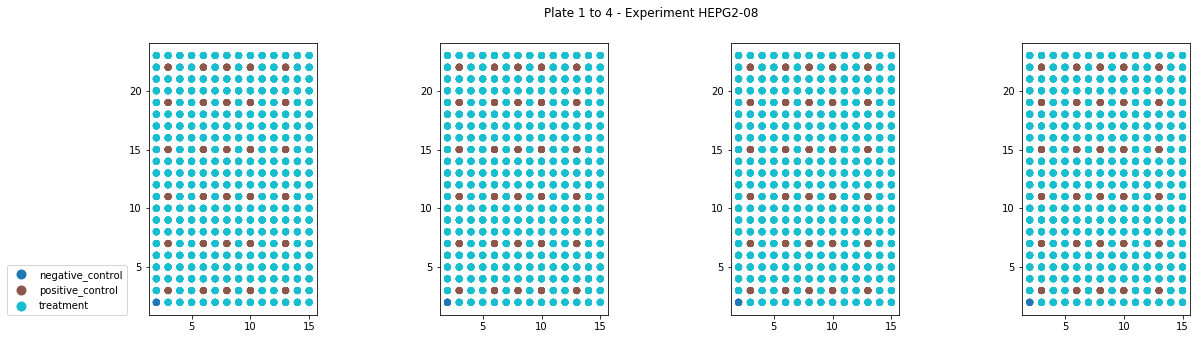

In [17]:
def plot_well_type_positions_for_experiment(experiment_name):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for plate, ax in zip([1,2,3,4], axes):
        one_plate_md = md[md.experiment==experiment_name]
        if plate==1:
            legend=True
        else:
            legend=False
        one_plate_md.plot(column='well_type',legend=legend, ax=ax);
        if plate==1:
            leg = ax.get_legend()
            leg.set_bbox_to_anchor((-0.3, 0., 0.2, 0.2))
    _ = fig.suptitle('Plate 1 to 4 - Experiment {}'.format(experiment_name))

plot_well_type_positions_for_experiment(md.experiment.unique()[0])
plot_well_type_positions_for_experiment(md.experiment.unique()[1])

Each plate holds the same 30 control siRNA conditions (positive controlled - RED), 277 different non-control siRNA (treatment - TURQUOISE), and one untreated well (negative control - BLUE). The well types follow the same architecture from one plate to another and experiment to another.

In [18]:
def plot_sirna_positions_for_experiment(experiment_name):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for plate, ax in zip([1,2,3,4], axes):
        one_plate_md = md[md.experiment==experiment_name]
        one_plate_md = one_plate_md[one_plate_md.well_type=='positive_control'] 
        one_plate_md.plot(column='sirna', ax=ax, categorical=True, cmap='tab20c');
    _ = fig.suptitle('Plate 1 to 4 - Experiment {}'.format(experiment_name))
    
plot_sirna_positions_for_experiment(md.experiment.unique()[0])
plot_sirna_positions_for_experiment(md.experiment.unique()[-1])

The location of each of the 1,108 non-control siRNA conditions is randomized in each experiment to prevent confounding effects of the location of a particular well.

### Algorithms and Techniques  

Our solution will use a convolutional neural network architecture, which is the defacto architecture for image classification ([source](https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8)).  
  
To further justify our decision to go along with a CNN architecture, it is to be said ResNet-50 have achieved very good results in multiclass image classification problems in the recent past ([see source](https://arxiv.org/abs/1903.10035)), having reached 98.87% accuracy when classifying histopathology images.  
We will thus use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) with a pretrained ResNet-18 on ImageNet to see if we obtain interesting results, and will use complex versions of it (Resnet-50, Resnet-152 or Densenet(s)) if this is successful.   

To use ResNet-18 properly, we will have to convert its first convolutional layer to support 6 channels instead of 3, and we will modify the final layer to support 1,108 output features (for the 1,108 possible siRNA classes).

### Benchmark
Since our solution uses a convolutional neural network architecture, we thus used a "vanilla" CNN model as our benchmark.  

The base model (see [full base-model notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/basemodel.ipynb)) was a very basic CNN model trained over 2 epochs on 6-channel 512x512 images. Here is the overall architecture:

----------

**Data**:
6-channels images, both sites.
Input resolution: 512x512

**Base model**:
Basic CNN model   

```  
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(6, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (fc1): Linear(in_features=65536, out_features=2216, bias=False)
  (fc2): Linear(in_features=2216, out_features=1108, bias=False)
)   
```   

**Loss**:
Cross Entropy Loss

**Optimizer**:  
Adam w/ lr=0.0003

**Epochs**:
2

**Framework**:
PyTorch

----------

This gave a cross-validation score of 0.0011 (.1% accuracy), and a test score of 0.002 (.2% accuracy). This score is a bit better than chance since we have 1108 classes. An accuracy reflecting chance would be 1/1108, which is equivalent to ~0.09% accuracy.


## III. Methodology

The full notebook for the ResNet-50 implementation and training can be accessed [here](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/resnet50_firststep.ipynb).

### Data Preprocessing

The competition's authors already provided utils to load the 6-channel images for each cell site under the method `rio.load_site`. Here is an example where we convert a site into its 6-channel images.

In [19]:
t = rio.load_site('train', 'RPE-05', 3, 'D19', 2, base_path="./data")
print(t.shape)
t_tensor_default = transforms.ToTensor()(t)
print(t_tensor_default.shape)

(512, 512, 6)
torch.Size([6, 512, 512])


This seems to work. Let's visualize individual channels.

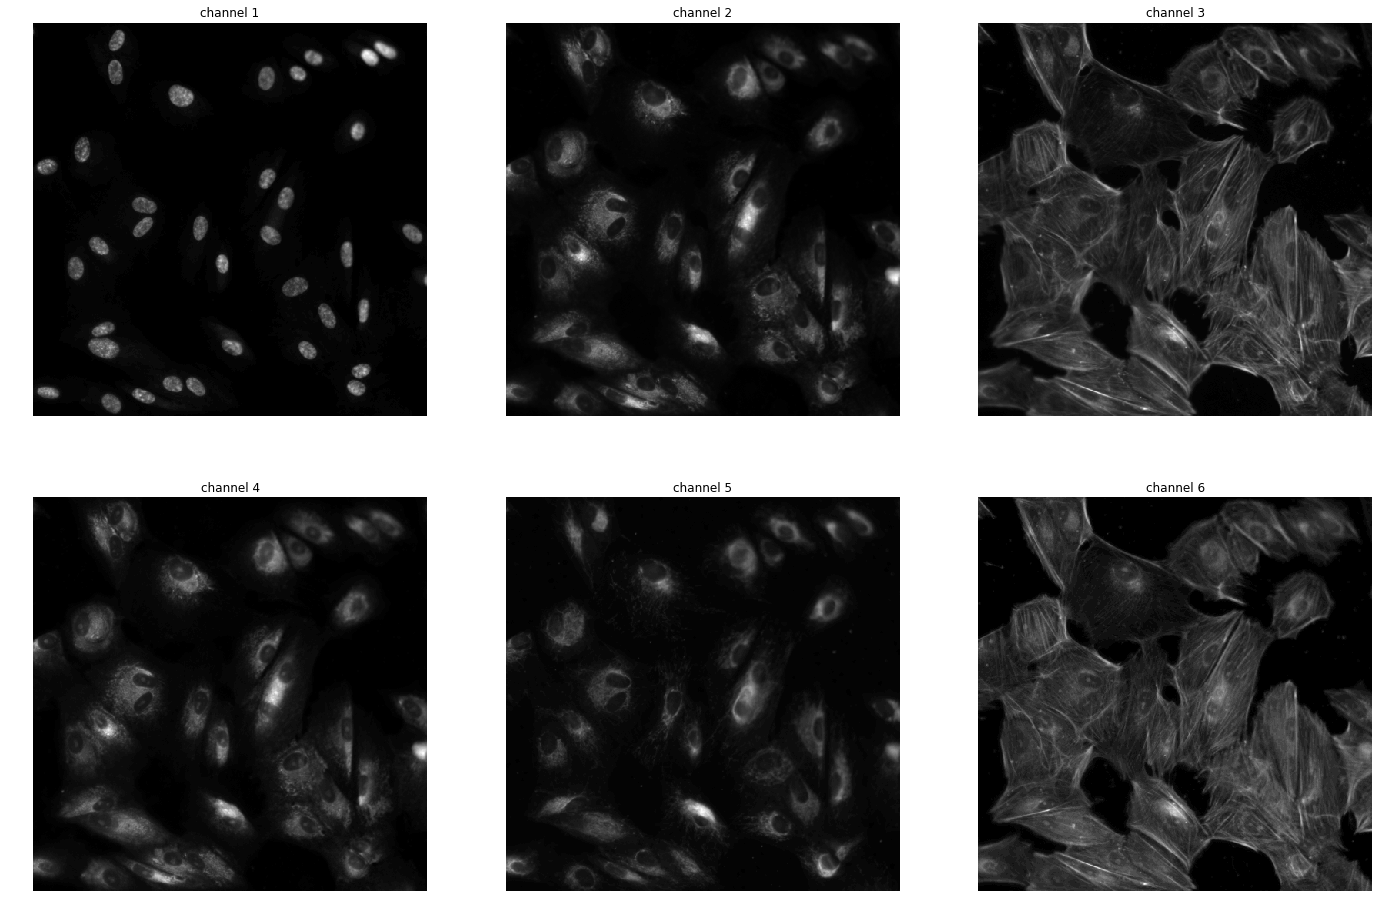

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')
  ax.set_title('channel {}'.format(i + 1))
  _ = ax.imshow(t[:, :, i], cmap='gray')

From there, all we had to do was to create the according PyTorch Image Dataset and DataLoader that would load the images with the above method, along with the labels (siRNA) provided in the metadata. Again, you can refer to the [notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/resnet50_firststep.ipynb) for further details.   

We decided to perform no further transformation, but we may be do so in upcoming iterations (see Discussion and Conclusion section).

### Implementation
See [notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/resnet50_firststep.ipynb) for full implementation of our model.

Despite the technical limitations encountered (which will be discussed in the Refinement section), I succeeded in using transfer learning and training a \[pre-trained on ImageNet\] ResNet-50 model with the 6-channel 512x512 images. The first convolutional layer was modified to accept 6 channels instead of 3 and the final layer was modified to be able to output 1 out of 1,108 classes. Here is an overview of the model architecture:   

----------

**Data**:
6-channels images, both sites.
Input resolution: 512x512

**Base model**:
ResNet-50 accepting 6-channel images as input and outputting 1108 possible classes.

**Loss**:
Cross Entropy Loss

**Optimizer**:  
Adam w/ lr=0.0003 + learning rate scheduler w/ gamma=0.95

**Epochs**:
15 epochs maximum

**Framework**:
PyTorch   

----------


### Refinement
After experimenting with different learning rates, we added early stopping and a learning rate scheduler decreasing the learning rate at each epoch. This resulted in considerable improvements in the final accuracy score of our model (~33% improvement).   

#### Two-step model training   

Many discussions and kernels on the competition's website talk about the relevance of taking a two-step approach to training our model: 1) train the model on all cell images, 2) train four seperate models on one of the four cell types (HEPG2, HUVEC, RPE, U2OS).

A two-step model training approach (credits [phalanx](https://www.kaggle.com/phalanx)):

<img src="https://raw.githubusercontent.com/michelml/ml-cellsignal/master/images/2step.png" alt="A two-step model training approach">    

I attempted such an implementation in the following notebooks based on [xhlulu's work](https://www.kaggle.com/xhlulu/recursion-2-headed-cnn-and-training-in-2-stages):   

- https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/cell_line_model_hepg2.ipynb  
- https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/cell_line_model_huvec.ipynb  
- https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/cell_line_model_rpe.ipynb  
- https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/cell_line_model_u2os.ipynb  

After these notebooks finished running, I aggregated the submission files and submitted the result on Kaggle. Results will be discussed in the next section.

#### Difficulties and technical limitations   
Since I started this competition a month ago, after my proposal had been accepted, I ran into several issues preventing me to experiment all the things I wanted to.   
First, I needed to upload the competition's data on FloydHub because this is where I have the most GPU credits, which is definitely needed for this competition. During this process, I corrupted the data and it took me a whole week to realize this was the problem. My models didn't want to train because of that, and the stacktrace and errors were not comprehensible. I was then back to square one after a week and a half of work.   

I then tried a second time to upload the data on FloydHub, but for unknown reasons, this time it was crashing at the middle of the almost-24-hour-long uploading process. I lost about three days trying to upload the data, to finally give up.   

This is at this moment that I started to work directly through Kaggle's kernels. However, Kaggle's kernels have limited resources and do not allow to train more complex models such as ResNet-152 or any Densenet - which appear to be one of the key in obtaining superior scores according to some of the competition's discussions.

Furthermore, kernels on Kaggle have a 9 hours computing time limit. This forces you to divide work across multiple kernels because the time to train models for this competition is quite long - 1 hour for the base model, 5+ hours for the ResNet-50, and most likely way more for more complex models with a lower learning rate (because more epochs before convergence).

Also, since [some discussions vent the merit of adopting a two-step model approach](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/100414#latest-586901) (a step to train the model on all the cell images, and a second step to train models on one of the four cell types (HEPG2, HUVEC, RPE, U2OS), training time can become exponentially long. 

Note that actions will be taken to solve all of those technical limitations in the upcoming weeks, but I couldn't have known these limitations ahead of time as a first time Kaggler.

## IV. Results
See [notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/resnet50_firststep.ipynb) for full results of our model.

### Model Evaluation and Validation
After experimenting with different learning rates, epochs, and learning schedules, we arrived at a best cross-validation score of 0.27 (27% accuracy), and a test score of 0.125 (12.5% accuracy). This score is way better than chance since we have 1108 classes. An accuracy reflecting chance would be 1/1108, which is equivalent to ~0.09% accuracy.

Disclaimer: you will actually see `10.4%` in the [ResNet-50 notebook](https://github.com/MichelML/ml-cellsignal/blob/master/my_notebooks/resnet50_firststep.ipynb). The best learning rate and gamma attempted thus far are `lr=0.0006` and `gamma=0.9`. Sadly, I only saved a notebook iteration with `lr=0.0003` and `gamma=0.95`. But, I however saved [the best weights of our model](https://github.com/MichelML/ml-cellsignal-models/tree/master/models). This means we could reload these weights on our pre-trained Resnet-50 model and reobtain the CV score of 0.27 and test score of 0.125.    

##### Two-step approach   
Our test score from a one-step approach to a two-step approach dropped by 0.03% in accuracy. This is surely due to a bad implementation on our part.   

First, there may be overfitting due to the fact that we were resplitting the data after the second step, which may cause validation data to enter the training data. Second, in [xhlulu's work](https://www.kaggle.com/xhlulu/recursion-2-headed-cnn-and-training-in-2-stages), they perform data augmentation through flipping and rotational changes, which may help the model generalize better.  

### Justification
We arrived at a best cross-validation score of 0.27 (27% accuracy), and a test score of 0.125 (12.5% accuracy). This score is way better than our benchmark of 0.2% accuracy or chance (0.09%).  

For further discussion, it seems that the lost function may not be the best indicator of our model performance. We obtained the minimum loss at the 6th epoch, but it resulted in a lower test accuracy score compared to the 10th epoch: 8.4% vs 10.4%.

#### Current usefulness of the model   
Despite our results are much better than chance, our current model is actually far from being useful for the problem at hand. Classifying siRNA with 10% accuracy wouldn't be helpful in modeling cellular images according to their relevant biology. In turn, it wouldn't greatly decrease the cost of treatments, and ensure these treatments get to patients faster.   

Thankfully, some competitors are already reaching >96% accuracy with their solutions.


## V. Conclusion

### Free-Form Visualization
Many useful visualizations have been provided in this final report. No further visualizations have been produced thus far.

### Reflection
I realized through this capstone that Kaggle's competitions are very powerful. There is nothing better than being part of competitions like this one and learning from experts from all over the world. The only thing I regret now is not taking part in such competitions earlier in my learning journey. It forces you to truly learn all the important concepts - given that you want to win the competition. I plan on continuing to participate in this kind of competitions in the future, hoping to grab the rank of Kaggle Master before 2020.   
  
Other useful reflections (some are directly taken from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/)):     

- Preparing the data in your prefered environment is no easy task.   
- Optimizing for fast training time early on will help you iterate faster. This means opting for simple solutions first, and complexify as you find interesting findings.   
- Set up the end-to-end training/evaluation skeleton + get dumb baselines.  
- Take the time to understand the domain, in our case the biology behind what we are doing. This helps mentally visualizing what we are doing better.

### Improvement
Many improvements remain to be made for the problem at hand, and I plan on doing so after graduating from this Nanodegree. Here is a list of possible improvements classified by specific "domain":  

##### Technical limitations  
- Succeed at uploading competition's data on FloydHub  
- Gain more computing resources once the data is uploaded on FloydHub 
- Try more complex models, more epochs, and lower learning rate. 

##### Two-step approach   
- Implement the two-step learning approach successfully.   
- Add data augmentation to this process to improve generalizability.   

##### Data augmentation
- Scaling
- Translation
- Rotation (at 90 degrees)
- Rotation (at finer angles)
- Flipping
- Adding Salt and Pepper noise
- Lighting condition
- Perspective transform  
- GANs to generate additional fake images
([source](https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9))

##### Training speed   
- Pre-compute images to tensors to avoid on-the-fly image loading.   
- Reduce image size.
- Use 3-channel images instead of 6. 

##### Image classification tricks     
- See [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://hackernoon.com/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-paper-discussion-693c9e17d1cc) by Sanyam Bhutani.  

##### Domain specific tricks   
- See biological tips [here](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/99171#latest-586564)   
- See conversation around the use of negative and positive controls [here](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/101826#latest-591591) and [here](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/100163#latest-590744).

# Special Thanks  
A heartfelt thanks to all the reviewers, mentors, and Udacity staff for this amazing journey.  

All the best.